In [19]:
import os
os.environ["GITHUB_TOKEN"] = ""

In [26]:
import requests
import csv
import os
import time
from urllib.parse import urlparse
from datetime import datetime, timezone

# ====== CONFIG ======
GITHUB_API_REST = "https://api.github.com"

HEADERS = {
    "Authorization": f"Bearer {os.environ['GITHUB_TOKEN']}",
    "Accept": "application/vnd.github+json"
}

# ====== TOP CONTRIBUTORS (REST) ======
def get_top_contributors(owner, repo, n=10):
    r = requests.get(
        f"{GITHUB_API_REST}/repos/{owner}/{repo}/contributors",
        headers=HEADERS,
        params={"per_page": n}
    )
    r.raise_for_status()
    return r.json()

# ====== SINGLE USER INFO (REST) ======
def get_user_info(login):
    r = requests.get(
        f"{GITHUB_API_REST}/users/{login}",
        headers=HEADERS
    )
    r.raise_for_status()
    return r.json()

# ====== MAIN PER-REPO FUNCTION ======
def fetch_repo_stats(repo_url):
    owner, repo = urlparse(repo_url).path.strip("/").split("/")[:2]

    # ---------- Repo metadata ----------
    r = requests.get(
        f"{GITHUB_API_REST}/repos/{owner}/{repo}",
        headers=HEADERS
    )
    r.raise_for_status()
    repo_data = r.json()

    # ---------- Contributors ----------
    contributors = get_top_contributors(owner, repo, 30)

    contributor_count = len(contributors)
    commits = [c.get("contributions", 0) for c in contributors]

    max_contributor_commits = max(commits, default=0)
    avg_contributor_commits = sum(commits) / contributor_count if contributor_count else 0

    # ---------- User-level stats ----------
    account_ages = []
    starred_repos = []

    for c in contributors:
        login = c.get("login")
        if not login:
            continue

        try:
            user = get_user_info(login)

            # account age
            created = datetime.fromisoformat(
                user["created_at"].replace("Z", "+00:00")
            )
            account_ages.append(
                (datetime.now(timezone.utc) - created).days
            )

            # starred repos
            starred_repos.append(user.get("public_repos", 0))

            time.sleep(0.1)  # REST-safe pacing
        except Exception:
            continue

    avg_account_age_days = sum(account_ages) / len(account_ages) if account_ages else 0
    max_account_age_days = max(account_ages, default=0)

    avg_starred_repos = sum(starred_repos) / len(starred_repos) if starred_repos else 0
    max_starred_repos = max(starred_repos, default=0)

    # ---------- Commits count (approx via contributors API) ----------
    commits_count = sum(commits)

    # ---------- FINAL RETURN ----------
    return {
        "repo_url": repo_url,
        "watchers_count": repo_data["watchers_count"],
        "forks_count": repo_data["forks_count"],
        "subscribers_count": repo_data["subscribers_count"],

        "project_size": repo_data["size"],
        "commits_count": commits_count,
        "open_issues_count": repo_data["open_issues_count"],
        "contributor_count": contributor_count,
        "max_contributor_commits": max_contributor_commits,
        "avg_contributor_commits": avg_contributor_commits,
        "avg_account_age_days": avg_account_age_days,
        "max_account_age_days": max_account_age_days,
        "avg_starred_repos": avg_starred_repos,
        "max_starred_repos": max_starred_repos
    }



In [27]:
def process_repos(txt_file, output_csv):
    with open(txt_file) as f:
        urls = [u.strip() for u in f if u.strip()]

    results = []

    for i, url in enumerate(urls, 1):
        try:
            print(f"[{i}/{len(urls)}] Processing {url}")
            results.append(fetch_repo_stats(url))
            time.sleep(0.5)  # polite pacing
        except Exception as e:
            print(f"Error on {url}: {e}")

    if results:
        with open(output_csv, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=results[0].keys())
            writer.writeheader()
            writer.writerows(results)

        print(f"\nSaved {len(results)} repos to {output_csv}")

# RUN
process_repos("repo_urls.txt", "repo_stats.csv")


[1/309] Processing https://github.com/avalon-lang/avaloni
[2/309] Processing https://github.com/alibaba/acqdp
[3/309] Processing https://github.com/quantastica/quantum-circuit
[4/309] Processing https://github.com/aws/amazon-braket-sdk-python
[5/309] Processing https://github.com/quantumlib/Cirq
[6/309] Processing https://github.com/NVIDIA/cuda-quantum
[7/309] Processing https://github.com/rigetti/pyquil
[8/309] Processing https://github.com/dwavesystems/dwave-ocean-sdk
[9/309] Processing https://github.com/QuTech-Delft/OpenQL
[10/309] Processing https://github.com/PennyLaneAI/pennylane
[11/309] Processing https://github.com/Quandela/Perceval
[12/309] Processing https://github.com/ProjectQ-Framework/ProjectQ
[13/309] Processing https://github.com/CQCL/pytket
[14/309] Processing https://github.com/microsoft/Quantum
[15/309] Processing https://github.com/pasqal-io/qadence
[16/309] Processing https://github.com/Qiskit/qiskit
[17/309] Processing https://github.com/eclipse-qrisp/Qrisp
[18/3

In [13]:
df = None

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ====== 1. LOAD DATA ======
df = pd.read_csv("repo_stats.csv")

# Ensure required columns exist
required_cols = [
    'watchers_count', 'forks_count', 'subscribers_count',
    'contributor_count', 'commits_count', 'avg_contributor_commits',
    'max_contributor_commits', 'avg_account_age_days', 'max_account_age_days',
    'avg_starred_repos', 'max_starred_repos', 'open_issues_count',
    'project_size',  # renamed from ambiguous 'size'
]
# Optional: include 'sbom_package_count' if present
optional_cols = ['sbom_package_count']

# ====== 2. TARGET ENGINEERING ======
# Composite popularity score with log1p to handle skew and zeros
df['popularity_score'] = np.log1p(
    df['watchers_count'] * 0.5 +
    df['forks_count'] * 0.3 +
    df['subscribers_count'] * 0.2
)

# Drop identifiers and target components to prevent leakage
cols_to_drop = [
    'repo_url', 'watchers_count', 'forks_count', 'subscribers_count', 'popularity_score'
]
X = df.drop(columns=cols_to_drop)
y = df['popularity_score']

# ====== 3. FEATURE ENGINEERING ======
# New engineered features
X['commit_concentration'] = X['max_contributor_commits'] / (X['avg_contributor_commits'] + 1e-5)
X['maintainer_experience'] = X['avg_account_age_days'] * X['contributor_count']
X['repo_engagement_ratio'] = X['avg_starred_repos'] / (X['project_size'] + 1)

# Handle infinities
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# ====== 4. PREPROCESSING PIPELINE ======
# Define skewed features (including engineered ones)
skewed_features = [
    'commits_count', 'avg_contributor_commits', 'avg_starred_repos',
    'max_contributor_commits', 'max_starred_repos', 'project_size',
    'open_issues_count', 'commit_concentration', 'repo_engagement_ratio'
]

# Custom skew reducer (log1p for high skew)
class SkewReducer:
    def __init__(self, skew_threshold=2.5):
        self.skew_threshold = skew_threshold
        self.features_to_transform = []

    def fit(self, X, y=None):
        self.features_to_transform = []
        for col in skewed_features:
            if col in X.columns and X[col].dtype in ['int64', 'float64']:
                skew_val = stats.skew(X[col].dropna())
                if abs(skew_val) > self.skew_threshold:
                    self.features_to_transform.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.features_to_transform:
            X[col] = np.log1p(X[col])
        return X

# Standard-scaled features (non-skewed, numeric)
standard_features = [
    'contributor_count', 'max_account_age_days',
    'avg_account_age_days', 'maintainer_experience'
]

# Ensure all columns are accounted for
remaining_cols = [col for col in X.columns if col not in skewed_features + standard_features]

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('skew_pipeline', Pipeline([
            ('skew_reducer', SkewReducer(skew_threshold=2.5)),
            ('yeo_johnson', PowerTransformer(method='yeo-johnson', standardize=False))
        ]), skewed_features),
        ('standard_features', StandardScaler(), standard_features)
    ],
    remainder='passthrough'
)

# ====== 5. SPLIT, IMPUTE, AND PROCESS ======
# Stratify on quantiles of target to preserve distribution
y_binned = pd.qcut(y, q=min(5, len(y) // 10), duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binned
)

# Impute missing values (median for numeric)
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Preprocess
X_train_processed = preprocessor.fit_transform(X_train_imputed)
X_test_processed = preprocessor.transform(X_test_imputed)

# Reconstruct column names
feature_names = (
    skewed_features +
    standard_features +
    remaining_cols
)
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# ====== 6. SAVE DATA ======
X_train_df.to_csv("X_train_processed.csv", index=False)
X_test_df.to_csv("X_test_processed.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

print("✅ Preprocessing complete!")
print(f"Training shape: {X_train_df.shape}, Test shape: {X_test_df.shape}")
print(f"Target skew after transformation: {stats.skew(y_train):.4f}")
print("\nTop 5 skewed features after preprocessing:")
skew_vals = X_train_df.apply(lambda x: stats.skew(x)).abs().sort_values(ascending=False)
print(skew_vals.head())

✅ Preprocessing complete!
Training shape: (246, 14), Test shape: (62, 14)
Target skew after transformation: 0.3152

Top 5 skewed features after preprocessing:
sbom_package_count       7.349248
repo_engagement_ratio    1.471418
max_account_age_days     1.416883
maintainer_experience    0.954429
contributor_count        0.731155
dtype: float64


Dataset shapes – Train: (246, 14), Test: (62, 14)
Analyzing contributor/project features: ['contributor_count', 'avg_account_age_days', 'max_account_age_days', 'avg_starred_repos', 'max_starred_repos', 'commit_concentration', 'maintainer_experience', 'project_size', 'sbom_package_count']

Training Ridge Regression
CV RMSE: 1.1397 ± 0.0954
CV R²:   0.5314 ± 0.0624
Test RMSE: 0.9716, Test R²: 0.5807

Training Random Forest
CV RMSE: 1.1088 ± 0.0743
CV R²:   0.5501 ± 0.0926
Test RMSE: 0.8369, Test R²: 0.6889

Training XGBoost
CV RMSE: 1.1766 ± 0.0902
CV R²:   0.4983 ± 0.0781
Test RMSE: 0.7594, Test R²: 0.7439

MODEL PERFORMANCE COMPARISON
                  cv_rmse_mean  cv_r2_mean  test_rmse   test_r2
Ridge Regression      1.139744    0.531390   0.971600  0.580672
Random Forest         1.108781    0.550136   0.836936  0.688854
XGBoost               1.176629    0.498318   0.759351  0.743868


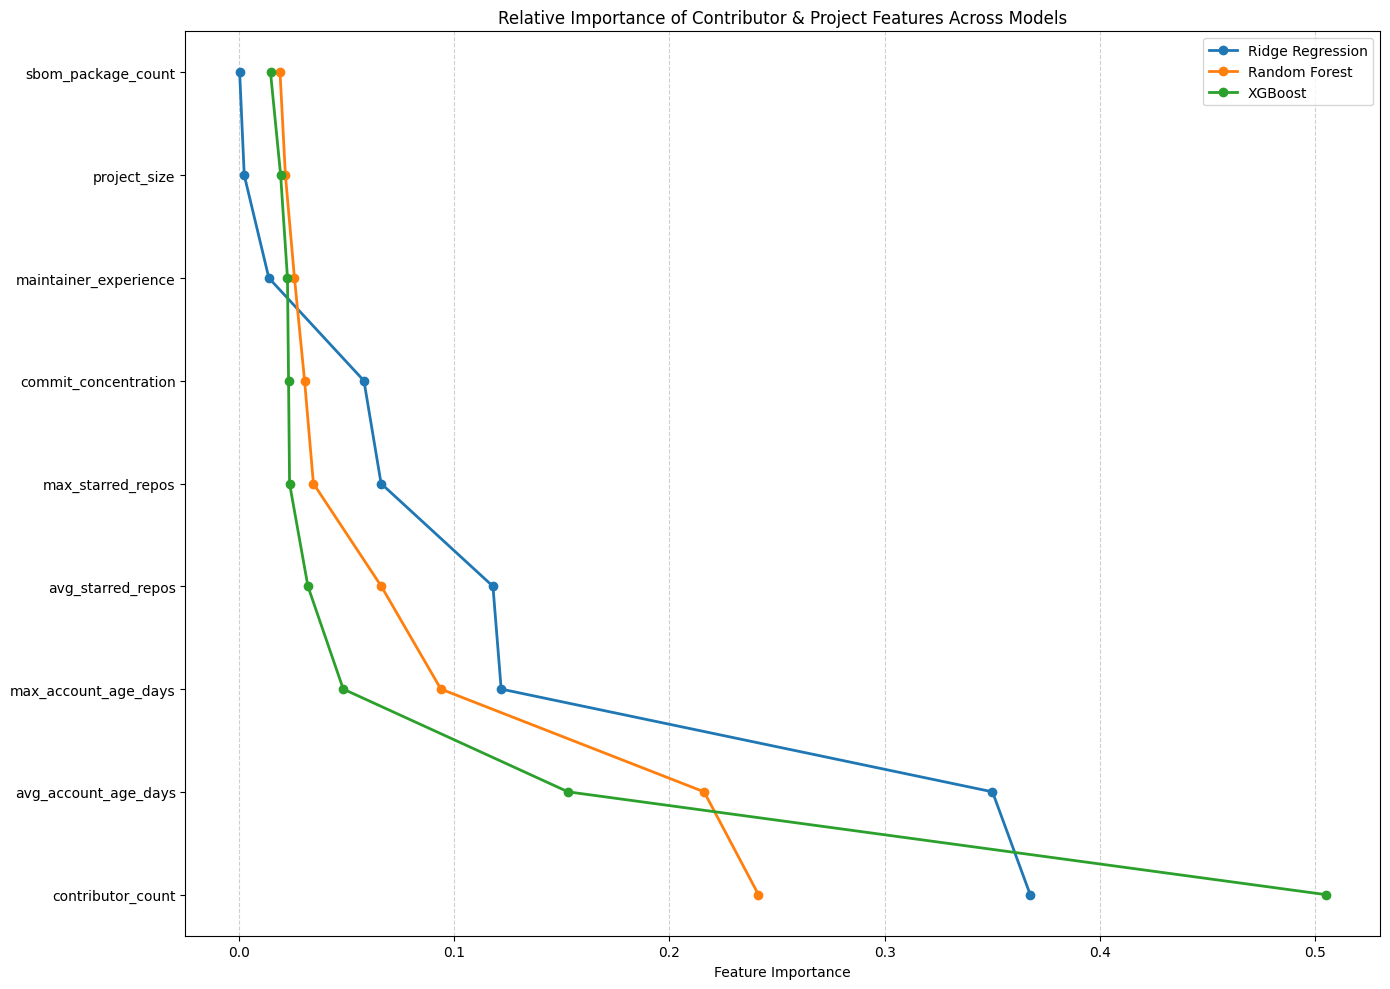


IMPACT OF CONTRIBUTOR & PROJECT FEATURES

Random Forest:
contributor_count        0.241363
maintainer_experience    0.216085
commit_concentration     0.093696
project_size             0.066017
sbom_package_count       0.034433
dtype: float64
→ Contributor/project features explain 74.8% of total importance

XGBoost:
contributor_count        0.505107
maintainer_experience    0.152841
commit_concentration     0.048310
project_size             0.031885
sbom_package_count       0.023339
dtype: float32
→ Contributor/project features explain 84.0% of total importance

SHAP ANALYSIS FOR BEST MODEL: XGBoost


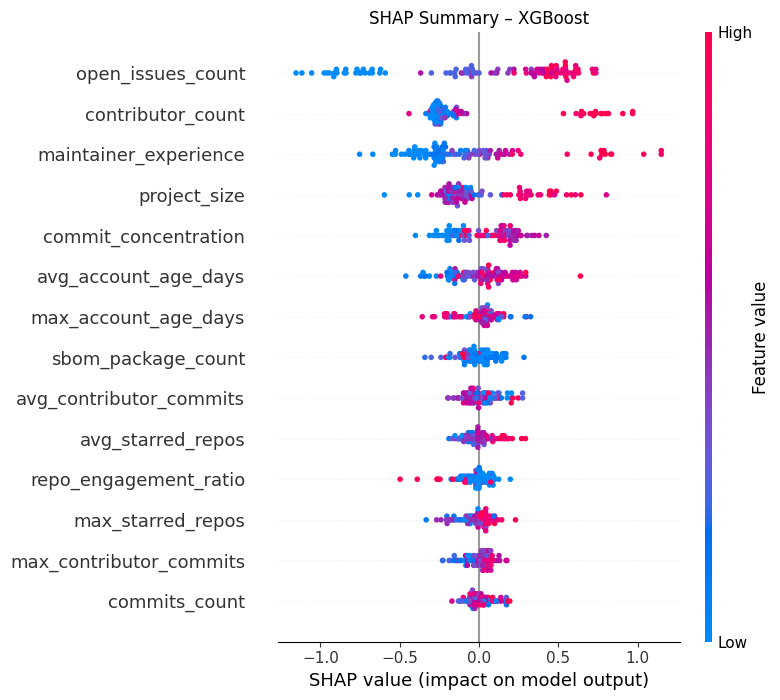

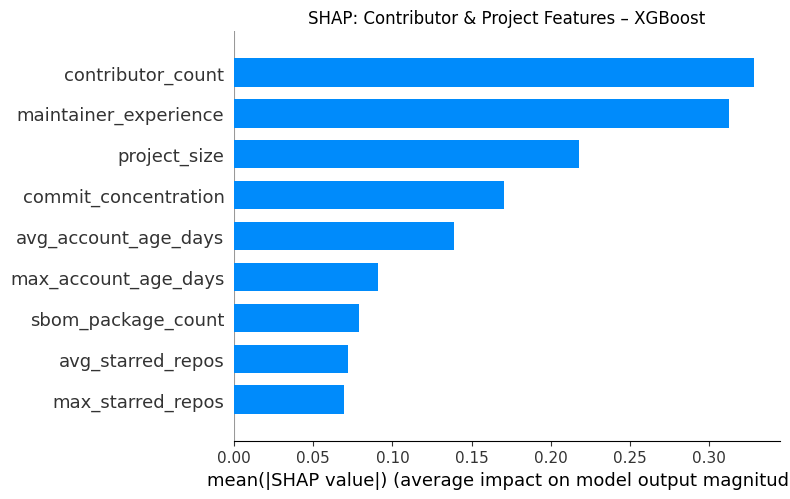

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import shap

# ====== 1. LOAD PROCESSED DATA ======
X_train = pd.read_csv("X_train_processed.csv")
X_test = pd.read_csv("X_test_processed.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

# Define features of interest (including new metrics)
potential_contrib_features = [
    'contributor_count', 'avg_account_age_days', 'max_account_age_days',
    'avg_starred_repos', 'max_starred_repos', 'commit_concentration',
    'maintainer_experience', 'project_size', 'sbom_package_count'
]

# Safely select only those present in data
contributor_features = [col for col in potential_contrib_features if col in X_train.columns]

print(f"Dataset shapes – Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Analyzing contributor/project features: {contributor_features}")

# ====== 2. MODEL TRAINING ======
models = {
    "Ridge Regression": RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='rmse',
        verbosity=0
    )
}

results = {}
feature_importances = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*50}\nTraining {name}\n{'='*50}")

    # Fit model
    if name == "XGBoost":
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)

    # Cross-validation
    cv_rmse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Test performance
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    results[name] = {
        'cv_rmse_mean': -cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std(),
        'cv_r2_mean': cv_r2.mean(),
        'cv_r2_std': cv_r2.std(),
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    print(f"CV RMSE: {results[name]['cv_rmse_mean']:.4f} ± {results[name]['cv_rmse_std']:.4f}")
    print(f"CV R²:   {results[name]['cv_r2_mean']:.4f} ± {results[name]['cv_r2_std']:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")

    # Feature importance
    if name == "Ridge Regression":
        importances = np.abs(model.coef_)
    else:
        importances = model.feature_importances_
    feature_importances[name] = pd.Series(importances, index=X_train.columns)

    # SHAP for tree models (sample 100 for speed)
    if name in ["Random Forest", "XGBoost"]:
        explainer = shap.TreeExplainer(model)
        sample = X_train.sample(n=min(100, len(X_train)), random_state=42)
        shap_vals = explainer.shap_values(sample)
        np.save(f"{name.lower().replace(' ', '_')}_shap_values.npy", shap_vals)

# ====== 3. RESULTS SUMMARY ======
results_df = pd.DataFrame(results).T
print(f"\n{'='*60}")
print("MODEL PERFORMANCE COMPARISON")
print(f"{'='*60}")
print(results_df[['cv_rmse_mean', 'cv_r2_mean', 'test_rmse', 'test_r2']])

# ====== 4. FEATURE IMPORTANCE PLOT ======
plt.figure(figsize=(14, 10))
for i, (name, imp) in enumerate(feature_importances.items()):
    contrib_imp = imp[contributor_features].sort_values(ascending=False)
    plt.plot(contrib_imp.values, range(len(contributor_features)), 'o-', label=name, linewidth=2, markersize=6)

plt.yticks(range(len(contributor_features)), contributor_features)
plt.xlabel("Feature Importance")
plt.title("Relative Importance of Contributor & Project Features Across Models")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("contributor_feature_importance.png", dpi=150, bbox_inches='tight')
plt.show()

# ====== 5. CONTRIBUTOR/PROJECT FEATURE IMPACT ======
print(f"\n{'='*60}")
print("IMPACT OF CONTRIBUTOR & PROJECT FEATURES")
print(f"{'='*60}")

for name in ["Random Forest", "XGBoost"]:
    imp_series = feature_importances[name][contributor_features].sort_values(ascending=False)
    total_imp = feature_importances[name].sum()
    contrib_imp_sum = imp_series.sum()
    print(f"\n{name}:")
    print(imp_series.head())
    print(f"→ Contributor/project features explain {contrib_imp_sum / total_imp:.1%} of total importance")

# ====== 6. SHAP ANALYSIS FOR BEST MODEL ======
best_model = results_df['test_r2'].idxmax()
print(f"\n{'='*60}")
print(f"SHAP ANALYSIS FOR BEST MODEL: {best_model}")
print(f"{'='*60}")

# Load and plot SHAP
shap_vals = np.load(f"{best_model.lower().replace(' ', '_')}_shap_values.npy", allow_pickle=True)
sample = X_train.sample(n=min(100, len(X_train)), random_state=42)

# Full SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_vals, sample, feature_names=X_train.columns, max_display=15, show=False)
plt.title(f"SHAP Summary – {best_model}")
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=120, bbox_inches='tight')
plt.show()

# Contributor/project-focused SHAP
contrib_indices = [X_train.columns.get_loc(f) for f in contributor_features]
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_vals[:, contrib_indices],
    sample[contributor_features],
    feature_names=contributor_features,
    plot_type="bar",
    show=False
)
plt.title(f"SHAP: Contributor & Project Features – {best_model}")
plt.tight_layout()
plt.savefig("shap_contributor_project.png", dpi=120, bbox_inches='tight')
plt.show()


In [16]:
try:
    # Display clean comparison of R² and RMSE (R² as "accuracy" proxy)
    comparison = results_df[['test_r2', 'test_rmse']].copy()
    comparison.columns = ['R² (Accuracy)', 'RMSE']
    comparison = comparison.round(4)
    print("Model Performance on Test Set:")
    print("-" * 35)
    print(comparison.to_string())
except NameError:
    print("Please run the model training cell first to generate results.")

Model Performance on Test Set:
-----------------------------------
                  R² (Accuracy)    RMSE
Ridge Regression         0.5807  0.9716
Random Forest            0.6889  0.8369
XGBoost                  0.7439  0.7594
